In [120]:
library(repr)
library(tidyverse)

library(tidymodels)
library(gridExtra)
options(repr.matrix.max.rows = 10)

# Classification

* We have to change the claim to something like this:

 *We can predict wether or not an individual is signed up to recieve news letter by using their age and experience level.*

 We do this by knn classification model and furthermore use our tools to check the accuracy (or precision) of the model that we built. 

In [121]:
players_data<-read_csv("https://raw.githubusercontent.com/lilypurdy/toy_ds_project/refs/heads/main/players%20(2).csv")
head(players_data, 5)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21


In [122]:
clean_players_data <- read_csv("https://raw.githubusercontent.com/Jamesnam1/toy_ds_project/refs/heads/main/players.csv",
    col_names = c("experience", "subscribed", "hashed_email", "hours_played", "name", "gender", "age"),
                col_types = list("c", "l", "c", "d", "c", "c", "i"))
clean_players_data

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


experience,subscribed,hashed_email,hours_played,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
experience,NA,hashedEmail,NA,name,gender,NA
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17


In [123]:
clean_players_data |>
  distinct(experience)

experience
<chr>
experience
Pro
Veteran
Amateur
Regular
Beginner


In [188]:
players <- clean_players_data |>
  select(-hashed_email, -subscribed, -name, -gender) |>
  filter(!is.na(age)) |>
  mutate(
    experience = case_when(
      experience == "Pro" ~ 5,
      experience == "Veteran" ~ 4,
      experience == "Amateur" ~ 3,
      experience == "Regular" ~ 2,
      experience == "Beginner" ~ 1,
      TRUE ~ NA_real_
    ), 
   level = case_when(
      hours_played > 40 ~ "high",
      hours_played <= 40 ~ "low"))|>
    arrange(-hours_played)
players

experience,hours_played,age,level
<dbl>,<dbl>,<int>,<chr>
2,223.1,17,high
2,218.1,20,high
2,178.2,19,high
3,150.0,16,high
3,56.1,23,high
⋮,⋮,⋮,⋮
1,0,17,low
3,0,17,low
3,0,20,low


In [189]:
players <- select(players, -hours_played)|>
    mutate(level = as_factor(level))
players

experience,age,level
<dbl>,<int>,<fct>
2,17,high
2,20,high
2,19,high
3,16,high
3,23,high
⋮,⋮,⋮
1,17,low
3,17,low
3,20,low


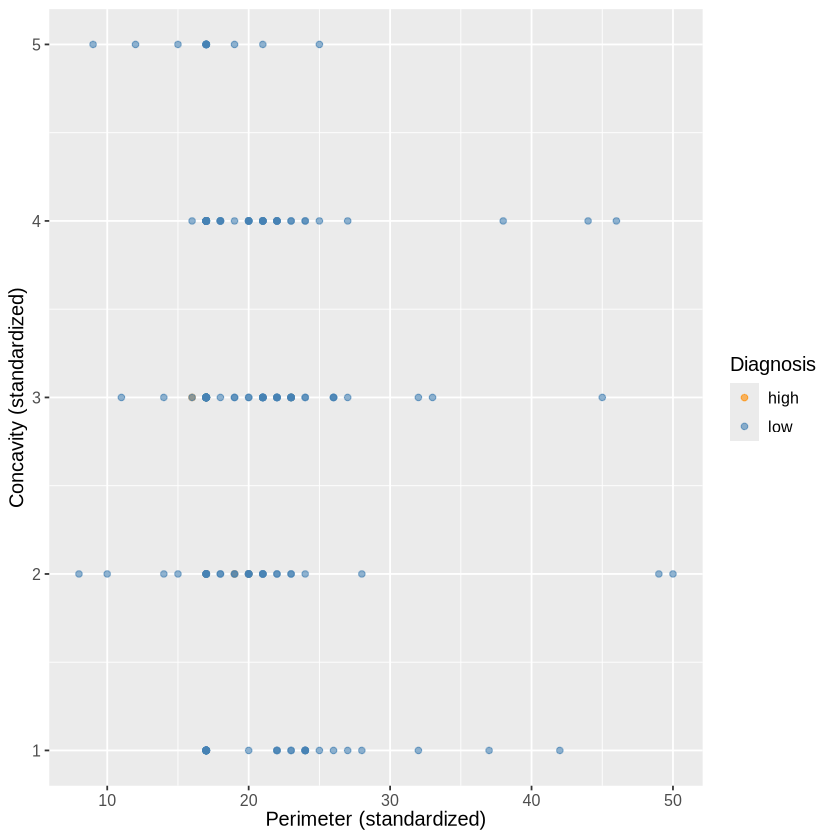

In [190]:
initial_scatter <- players |>
  ggplot(aes(x = age, y = experience, color = level)) +
  geom_point(alpha = 0.6) +
  labs(x = "Perimeter (standardized)",
       y = "Concavity (standardized)",
       color = "Diagnosis") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))
initial_scatter

In [230]:
set.seed(1)

split_data <- initial_split(players, prop = 3/4, strata = level)

training_data <- training(split_data)
testing_data <- testing(split_data)

head(training_data)

experience,age,level
<dbl>,<int>,<fct>
2,17,high
2,20,high
3,17,high
1,24,low
4,27,low
1,17,low


In [231]:
set.seed(1)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) |>
  set_engine("kknn") |>
  set_mode("classification")

In [232]:
set.seed(1)
player_split <- initial_split(training_data, prop = 0.75, strata = level)
player_subtrain <- training(player_split)
player_validation <- testing(player_split)
head(player_subtrain)

experience,age,level
<dbl>,<int>,<fct>
2,17,high
2,20,high
1,17,low
2,17,low
3,21,low
4,22,low


In [233]:
set.seed(1)
player_recipe <- recipe(level ~ age + experience,
                        data = player_subtrain) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_fit <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_spec) |>
  fit(data = player_subtrain)

validation_predicted <- predict(knn_fit, player_validation) |>
  bind_cols(player_validation)

acc <- validation_predicted |>
  metrics(truth = level, estimate = .pred_class) |>
  filter(.metric == "accuracy") |>
  select(.estimate) |>
  pull()

acc

[1] 0.972973

In [236]:
set.seed(1)
player_vfold <- vfold_cv(training_data, v = 10, strata = level)

In [239]:
set.seed(1)

player_recipe <- recipe(level ~ age + experience,
                        data = training_data) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_fit <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_spec) |>
  fit_resamples(resamples = player_vfold) |>
    collect_metrics()

knn_fit

ERROR: [1m[33mError[39m:[22m
[33m![39m 1 argument has been tagged for tuning in this component: model_spec. 
Please use one of the tuning functions (e.g. `tune_grid()`) to optimize them.


In [240]:
set.seed(1)
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

In [ ]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>
  add_recipe(cancer_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = cancer_vfold, grid = k_vals) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies

In [ ]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

In [77]:


Wdbc_recipe <- recipe(level ~ age + experience, data = players) |>                     
  step_center(all_predictors()) |>  
  step_scale(all_predictors())     

Wdbc_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("classification")

Wdbc_workflow <- workflow() |>
  add_recipe(Wdbc_recipe) |>
  add_model(Wdbc_model)

Wdbc_fit <- Wdbc_workflow |>
  fit(data = players)

new_obs <- tibble(age = 18, experience = 4)  
predict(Wdbc_fit, new_obs)

.pred_class
<fct>
low
